In [1]:
# TODO: A more generic way is needed here to load the path
import sys

sys.path.append(
    "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
    # "/global/homes/p/peishi89/jax-watershed/src"
)

In [2]:
from pathlib import Path

from math import floor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import jax.numpy as jnp

from jax_canoak.subjects.utils import es as fes

# from jax_canoak.shared_utilities.forcings.get_forcing import get_modis_lai
# from jax_canoak.shared_utilities.forcings.get_forcing import get_modis_et

%load_ext autoreload
%autoreload 2

In [3]:
site = "US-Bi1"
dir_flux_data = Path(f"../data/fluxtower/{site}")
dir_modis_data = Path(f"../data/modis/{site}")

f_forcing = (
    dir_flux_data
    / "AMF_US-Bi1_FLUXNET_FULLSET_2016-2021_3-5"
    / "AMF_US-Bi1_FLUXNET_FULLSET_HH_2016-2021_3-5.csv"
)
f_chamber = dir_flux_data / "BouldinAlfalfaForcedDiffusion2018_2021.csv"
f_modis_lai = dir_modis_data / "MCD15A3H" / "filtered_scaled_Lai_500m.csv"
f_modis_le = dir_modis_data / "MOD16A2GF" / "filtered_scaled_LE_500m.csv"

# modis_lai_scale_factor = 0.1
modis_lai_scale_factor = 1
modis_le_scale_factor = 1e4
pixel_ind = 144

# Flux tower data

In [4]:
# Read the dataframe
df = pd.read_csv(f_forcing)

In [5]:
# Get the time frame
df.index = pd.to_datetime(df["TIMESTAMP_END"], format="%Y%m%d%H%M")

In [6]:
# Vegetation height
df["veg_ht"] = 0.8

<Axes: xlabel='TIMESTAMP_END'>

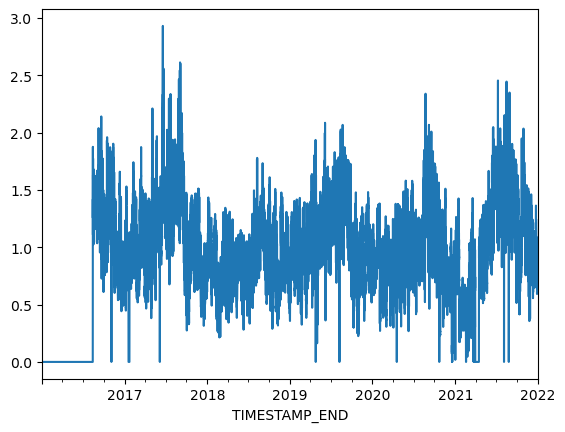

In [7]:
# Calculate vapor pressure from air temperature and relative humidity
es = fes(df["TA_F"].values + 273.15)
# ea = es - df['VPD'].values*1000
df["RH"] = np.clip(df["RH"], a_max=100, a_min=0)
ea = es * df["RH"].values / 100

df["eair"] = ea / 1e3  # kPa
df["eair"].plot()

# Soil respiration

In [8]:
df_soil = pd.read_csv(f_chamber)
df_soil["hour"] = df_soil["hhmm"].apply(lambda x: floor(x / 100))
df_soil["min"] = df_soil["hhmm"] - df_soil["hour"] * 100
df_soil["doy"] = df_soil["doy"].apply(lambda x: str(x).zfill(3))

In [9]:
df_soil.index = pd.to_datetime(
    df_soil["year"].astype(str)
    + df_soil["doy"].astype(str)
    + df_soil["hour"].astype(str)
    + df_soil["min"].astype(str),
    format="%Y%j%H%M",
)

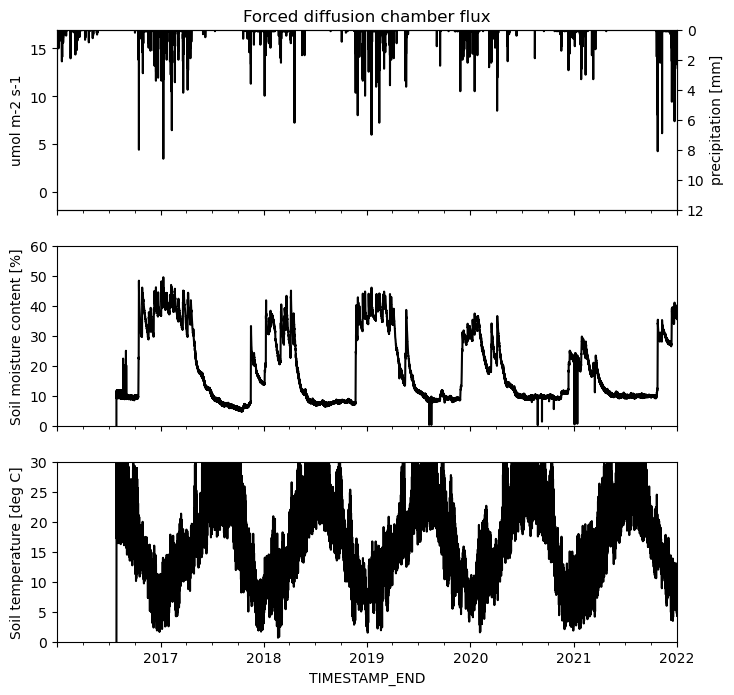

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)
ax = axes[0]
df_soil["BA_met f_FD_Flux"].plot(ax=ax, label="FD")
df_soil["BA_met f_FD_B_Flux"].plot(ax=ax, alpha=0.5, label="FD_B")
ax.set(
    title="Forced diffusion chamber flux",
    ylabel="umol m-2 s-1",
    # xlim=[df_soil.index[10000], df_soil.index[15000]])
    xlim=[df_soil.index[-5001], df_soil.index[-1]],
)
# ax.legend()
ax2 = ax.twinx()
df["P_F"].plot(ax=ax2, color="black", label="precip")
ax2.set(ylabel="precipitation [mm]", ylim=[12, 0])

ax = axes[1]
df["SWC_F_MDS_1"].plot(ax=ax, color="black", label="soil moisture content")
ax.set(ylabel="Soil moisture content [%]", ylim=[0, 60])

ax = axes[2]
# df['SWC_F_MDS_1'].plot(ax=ax2, color='black', label='soil moisture content')
# ax2.set(ylabel='Soil moisture content [%]', ylim=[60, 0])
# ax2.invert_yaxis()
df["TS_F_MDS_1"].plot(ax=ax, color="black", label="Soil temperature")
ax.set(ylabel="Soil temperature [deg C]", ylim=[0, 30]);

In [11]:
df_soil = df_soil[["BA_met f_FD_Flux"]]
df_soil.rename(columns={"BA_met f_FD_Flux": "Rsoil"}, inplace=True)

# MODIS data


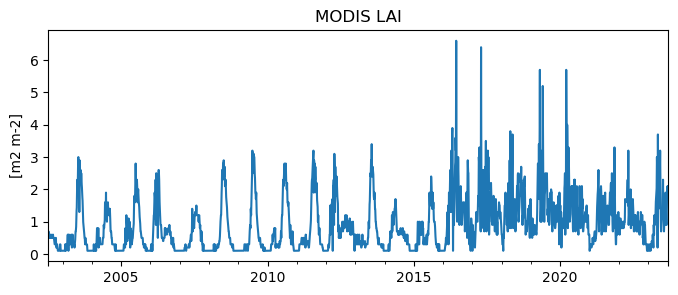

In [12]:
df_modis_lai = pd.read_csv(f_modis_lai, header=None)
df_modis_lai.index = df_modis_lai[2].apply(
    lambda x: pd.to_datetime(x[1:], format="%Y%j")
)
df_modis_lai["LAI"] = df_modis_lai[4 + pixel_ind].apply(
    lambda x: float(x) / modis_lai_scale_factor if x != "F" else np.nan
)
df_modis_lai = df_modis_lai[["LAI"]]
df_modis_lai = df_modis_lai.resample("30min").interpolate()
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
df_modis_lai["LAI"].plot(ax=ax)
ax.set(title="MODIS LAI", xlabel="", ylabel="[m2 m-2]");

<Axes: xlabel='2'>

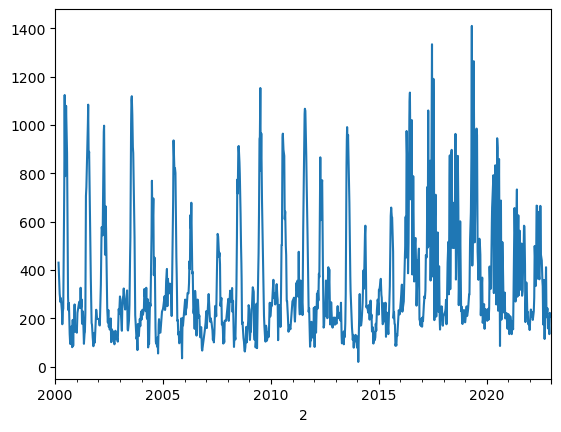

In [13]:
df_modis_le = pd.read_csv(f_modis_le, header=None)
df_modis_le.index = df_modis_le[2].apply(lambda x: pd.to_datetime(x[1:], format="%Y%j"))
df_modis_le["LE_MODIS"] = df_modis_le[4 + pixel_ind].apply(
    lambda x: float(x) / modis_le_scale_factor if x != "F" else np.nan
)
df_modis_le = df_modis_le[["LE_MODIS"]]
df_modis_le = df_modis_le.resample("30min").interpolate()
df_modis_le["LE_MODIS"].plot()

In [14]:
df_modis = pd.concat([df_modis_lai, df_modis_le])
df_modis.head()

,LAI,LE_MODIS
2,,
2002-07-04 00:00:00,0.500000,NaN
2002-07-04 00:30:00,0.501042,NaN
2002-07-04 01:00:00,0.502083,NaN
2002-07-04 01:30:00,0.503125,NaN
2002-07-04 02:00:00,0.504167,NaN


In [15]:
# Compute the LAI at the flux tower

In [16]:
# data_json['subset'][5]['data']
# Get MODIS LAI
# start, end = df.index[0], df.index[-1]
# df_modis = get_modis_lai("US-Hn1", start, end, method='mean', sample_freq="30min")
# df_modis, data_json = get_modis_lai(
#   "US-Hn1", start, end, method='mean', sample_freq="30min"
# )
# df_modis["LAI"].plot()

In [17]:
# df_modis = pd.read_csv(f_modis_lai, header=None)
# df_modis.index = df_modis[2].apply(lambda x: pd.to_datetime(x[1:], format="%Y%j"))
# df_modis["LAI"] = df_modis[6].apply(
#     lambda x: float(x) / modis_lai_scale_factor if x != "F" else np.nan
# )
# df_modis = df_modis[["LAI"]]
# df_modis = df_modis.resample("30min").interpolate()
# df_modis["LAI"].plot()

# Combine data

In [18]:
df = df.join(df_modis)
df = df.join(df_soil[["Rsoil"]])

# Forcings

In [19]:
df[df == -9999] = np.nan

In [20]:
df["Year"] = df.index.year
df["DoY"] = df.index.day_of_year
df["Hour"] = df.index.hour + df.index.minute / 60.0
df["SWC_F_MDS_1"] = df["SWC_F_MDS_1"] / 100.0

In [21]:
# list(df.keys())
df["TA_F_QC"]

TIMESTAMP_END
2016-01-01 00:30:00    2
2016-01-01 00:30:00    2
2016-01-01 01:00:00    2
2016-01-01 01:00:00    2
2016-01-01 01:30:00    2
                      ..
2021-12-31 23:00:00    0
2021-12-31 23:30:00    0
2021-12-31 23:30:00    0
2022-01-01 00:00:00    0
2022-01-01 00:00:00    0
Name: TA_F_QC, Length: 218046, dtype: int64

In [22]:
# The following information is needed to drive CANOAK
in_varns = [
    "Year",
    "DoY",
    "Hour",
    "TA_F",
    "SW_IN_F",
    "eair",
    "WS_F",
    "CO2_F_MDS",
    "PA_F",
    "USTAR",
    "TS_F_MDS_4",
    "SWC_F_MDS_1",
    "veg_ht",
    "LAI",
]

<Axes: xlabel='TIMESTAMP_END'>

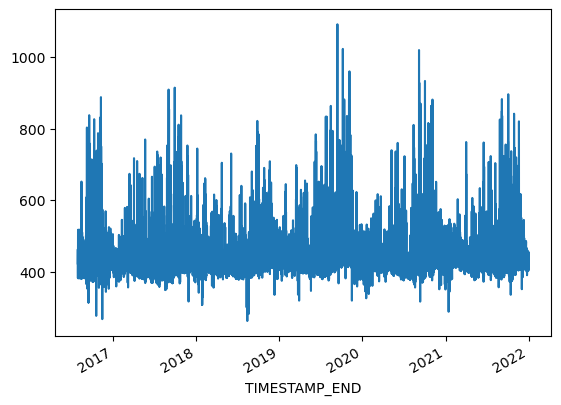

In [25]:
# Clean up the negative CO2 ppm
df.loc[df["CO2_F_MDS"] <= 100, "CO2_F_MDS"] = np.nan
df["CO2_F_MDS"].plot()

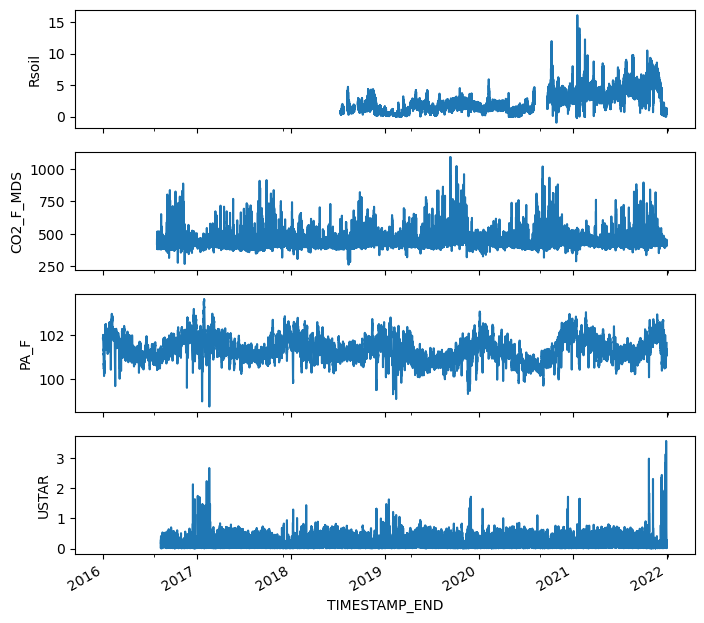

In [26]:
varns = ["Rsoil", "CO2_F_MDS", "PA_F", "USTAR"]
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 8), sharex=True)
for i, varn in enumerate(varns):
    ax = axes[i]
    df[varn].plot(ax=ax)
    ax.set(ylabel=varn)

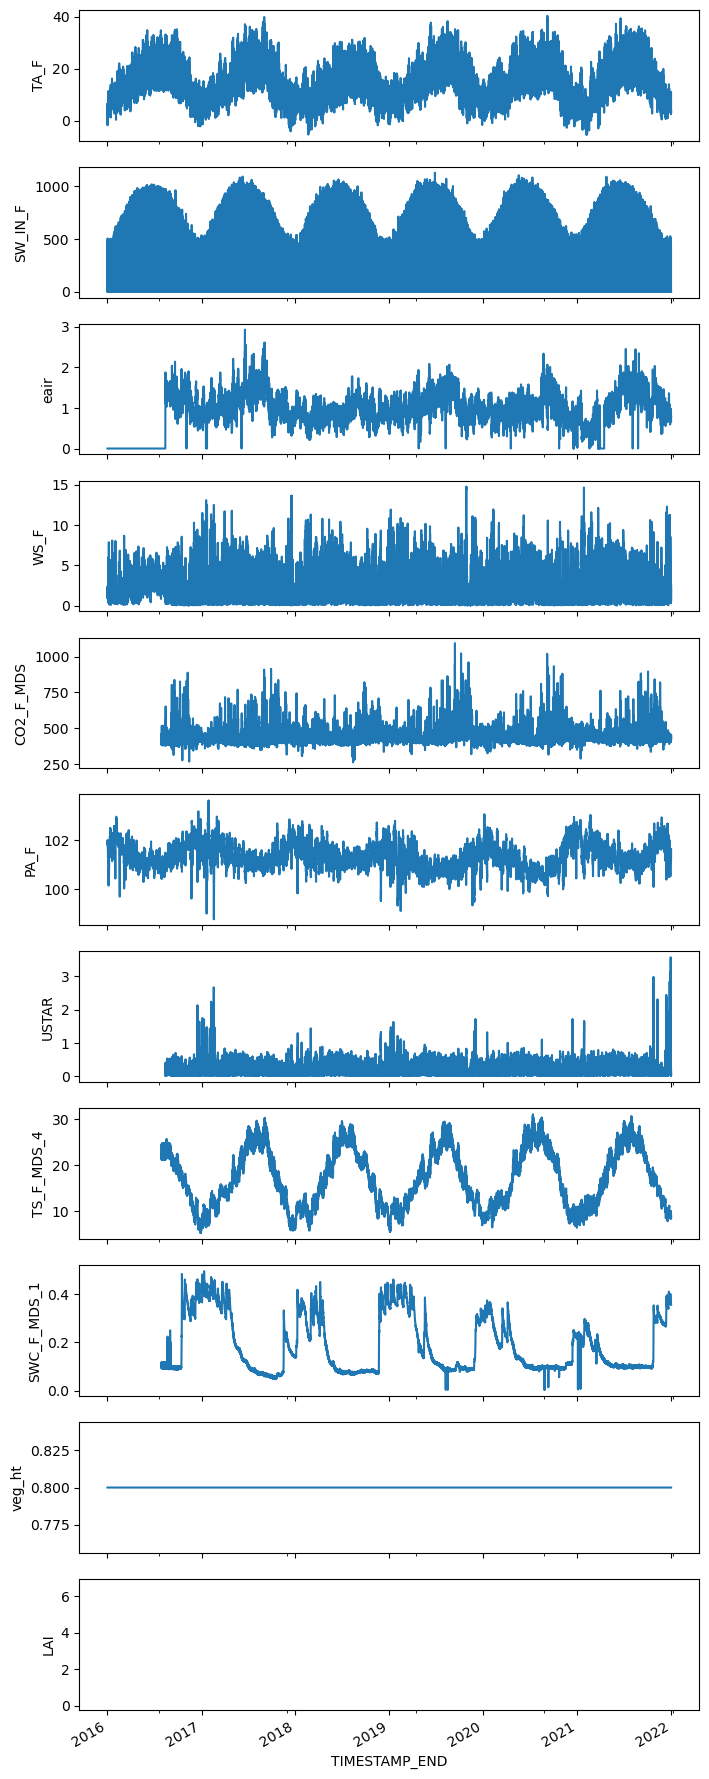

In [27]:
varns = in_varns[3:]
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 25), sharex=True)
for i, varn in enumerate(varns):
    ax = axes[i]
    df[varn].plot(ax=ax)
    ax.set(ylabel=varn)

In [24]:
# varns = ['TA_F', 'LE_F_MDS', 'eair', 'SWC_F_MDS_1', 'CO2_F_MDS']
# # start, end = "2017-06-01", "2017-06-30"
# # start, end = "2017-06-22", "2017-06-30"
# fig, axes = plt.subplots(len(varns), 1, figsize=(8, 10))
# for i, varn in enumerate(varns):
#     ax = axes[i]
#     # df.loc[start:end, varn].plot(ax=ax)
#     df.plot(ax=ax)
#     ax.set(ylabel=varn)

In [28]:
# Save the forcing data
# start, end = "2016-06-01", "2017-06-30"
# start, end = "2018-07-01", "2020-06-30"
# start, end = "2018-12-01", "2019-12-30"
start, end = "2018-12-01", "2018-12-30"
df_save = df[in_varns][start:end]
df_save.interpolate(inplace=True)
np.savetxt(dir_flux_data / "US-Bi1-forcings-short.csv", df_save.values, delimiter=",")

# Responses/fluxes/rain

In [30]:
df_soil["Rsoil"]["2019-05-27":"2019-05-28"].sort_index()

2019-05-27 00:00:00    1.16
2019-05-27 01:00:00    1.35
2019-05-27 02:00:00    1.27
2019-05-27 03:00:00    1.38
2019-05-27 03:00:00    1.18
                       ... 
2019-05-28 22:00:00    1.68
2019-05-28 22:30:00    1.73
2019-05-28 23:00:00    1.89
2019-05-28 23:00:00    1.77
2019-05-28 23:30:00    1.72
Name: Rsoil, Length: 96, dtype: float64

[Text(0, 0.5, '[umol m-2 s-1]'), Text(0.5, 1.0, 'FD')]

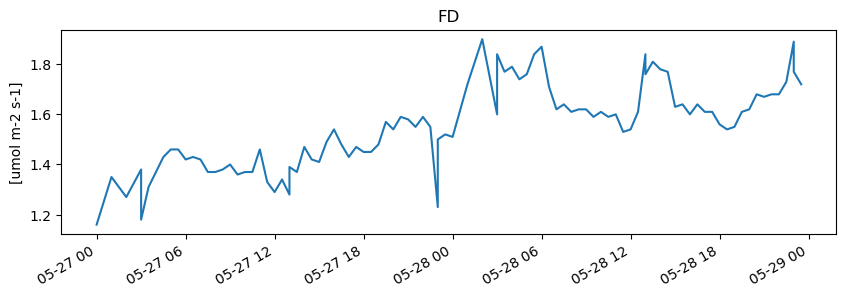

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
# df_soil['Rsoil']['2019-05-27':'2019-06-06'].plot(ax=ax)
df_soil["Rsoil"]["2019-05-27":"2019-05-28"].plot(ax=ax)
ax.set(ylabel="[umol m-2 s-1]", title="FD")

In [32]:
df["Rsoil"].iloc[101000:101500]

TIMESTAMP_END
2018-11-10 12:30:00    2.60
2018-11-10 12:30:00    2.60
2018-11-10 13:00:00    2.94
2018-11-10 13:00:00    2.48
2018-11-10 13:00:00    2.94
                       ... 
2018-11-15 08:30:00    4.00
2018-11-15 09:00:00    4.16
2018-11-15 09:00:00    4.16
2018-11-15 09:30:00    2.89
2018-11-15 09:30:00    2.89
Name: Rsoil, Length: 500, dtype: float64

[Text(0, 0.5, '[umol m-2 s-1]'), Text(0.5, 1.0, 'FD')]

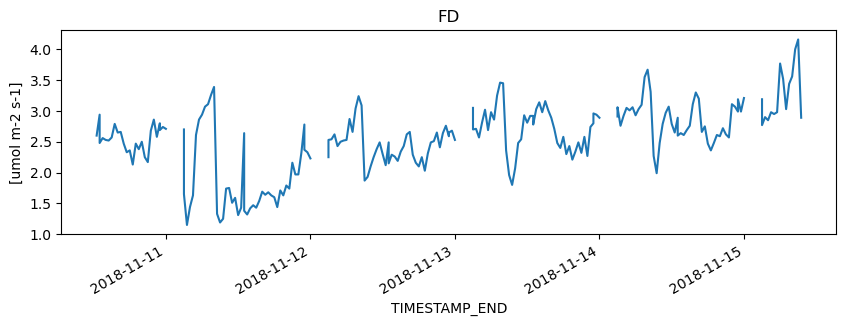

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
df["Rsoil"].iloc[101000:101500].plot(ax=ax)
ax.set(ylabel="[umol m-2 s-1]", title="FD")

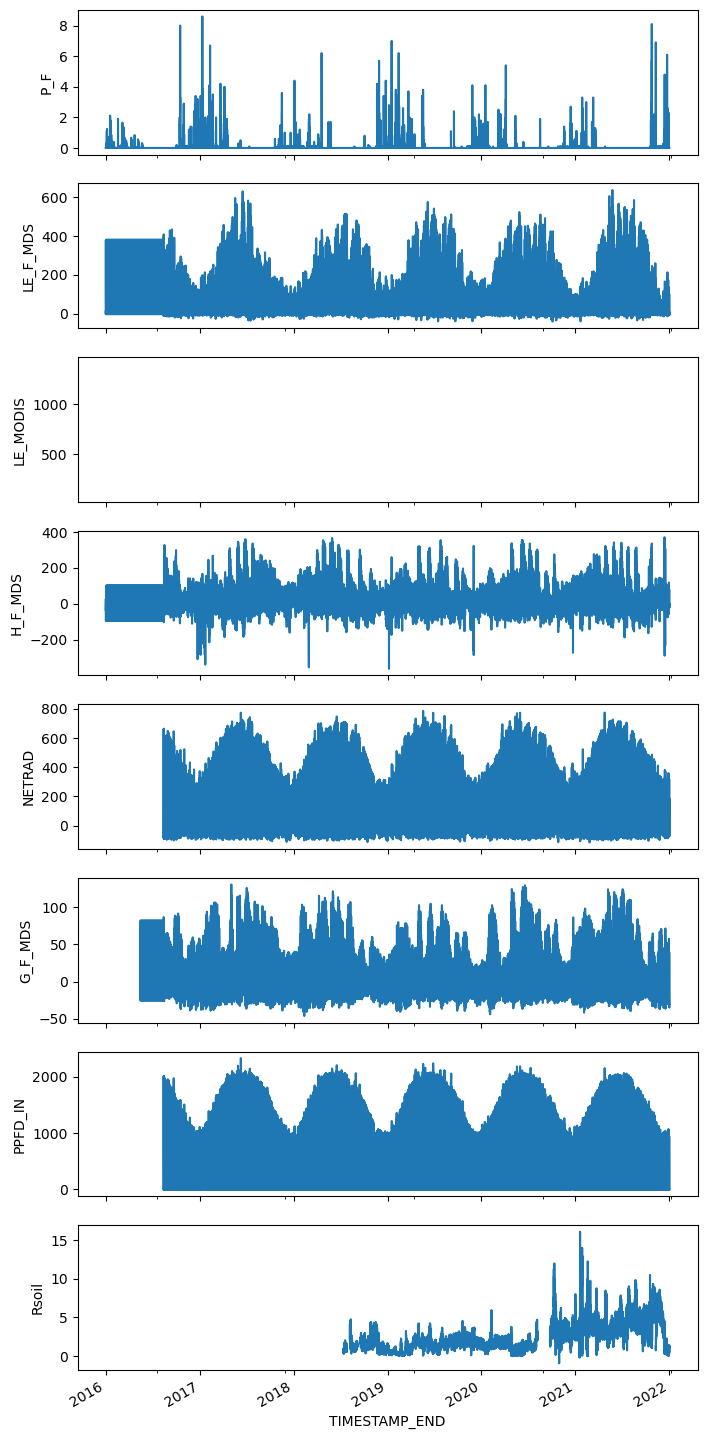

In [34]:
# The data to compare
out_varns = [
    "P_F",
    "LE_F_MDS",
    "LE_MODIS",
    "H_F_MDS",
    "NETRAD",
    "G_F_MDS",
    "PPFD_IN",
    "Rsoil",
]
varns = out_varns
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 20), sharex=True)
for i, varn in enumerate(varns):
    ax = axes[i]
    df[varn].plot(ax=ax)
    ax.set(ylabel=varn)

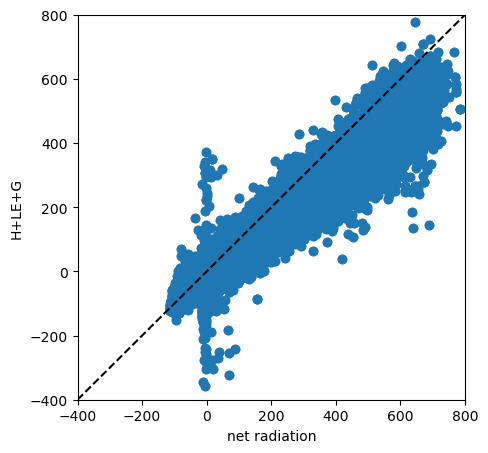

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
lim = [-400, 800]
ax.scatter(df["NETRAD"], df["H_F_MDS"] + df["LE_F_MDS"] + df["G_F_MDS"])
ax.plot(lim, lim, "k--")
ax.set(xlim=lim, ylim=lim, xlabel="net radiation", ylabel="H+LE+G");

In [36]:
# Save the data to compare
df_save = df[out_varns][start:end]
df_save.interpolate(inplace=True)
# np.savetxt('US-Hn1-fluxes.csv', df_save.values, delimiter=',')
df_save.to_csv(dir_flux_data / "US-Bi1-fluxes-short.csv", sep=",")